In [27]:
import numpy as np
import scipy.optimize as opt
import optuna
import pandas as pd
import matplotlib.pyplot as plt

## Rosenbrock, Himmelblau visualization

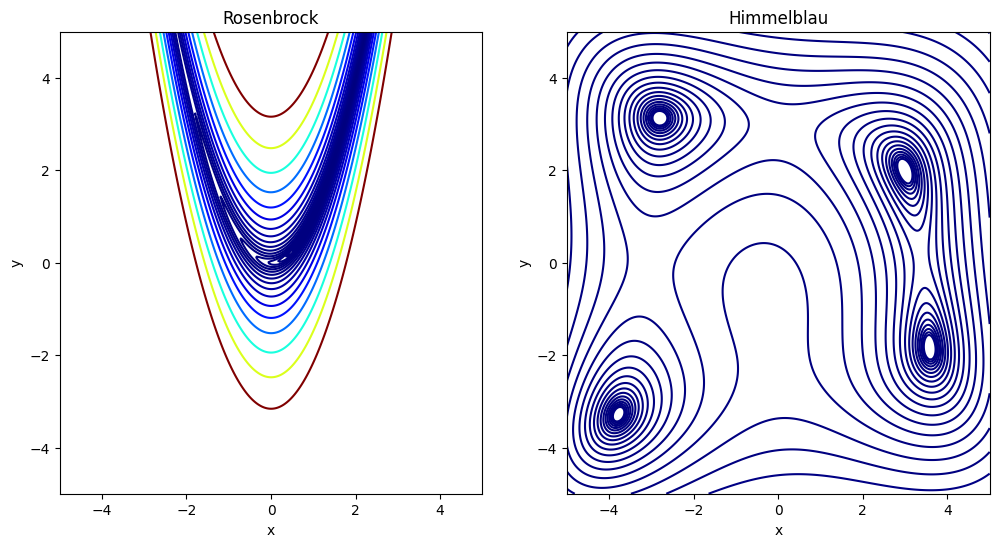

In [25]:
def rosenbrock(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2


def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)

Z_rosenbrock = rosenbrock(X, Y)
Z_himmelblau = himmelblau(X, Y)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))


ax[0].contour(X, Y, Z_rosenbrock, levels=np.logspace(-1, 3, 20), cmap='jet')
ax[0].set_title('Rosenbrock')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].contour(X, Y, Z_himmelblau, levels=np.logspace(0, 5, 35), cmap='jet')
ax[1].set_title('Himmelblau')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

plt.show()


## Simulated Annealing

In [13]:
def simulated_annealing(func, bounds, initial_temp, cooling_rate, max_iter):
    current_temp = initial_temp
    current_solution = np.random.uniform(bounds[0], bounds[1])
    current_value = func(current_solution)

    for i in range(max_iter):
        new_solution = current_solution + np.random.uniform(-1, 1)
        new_value = func(new_solution)

        if new_value < current_value or np.exp((current_value - new_value) / current_temp) > np.random.rand():
            current_solution = new_solution
            current_value = new_value

        current_temp *= cooling_rate

    return current_solution, current_value

def example_function(x):
    return x**2 + 4*np.sin(5*x)

bounds = [-10, 10]
initial_temp = 1000
cooling_rate = 0.95
max_iter = 1000

best_solution, best_value = simulated_annealing(example_function, bounds, initial_temp, cooling_rate, max_iter)
print("Лучшее решение:", best_solution)
print("Значение функции:", best_value)

Лучшее решение: -0.3086226463056774
Значение функции: -3.903219452540726


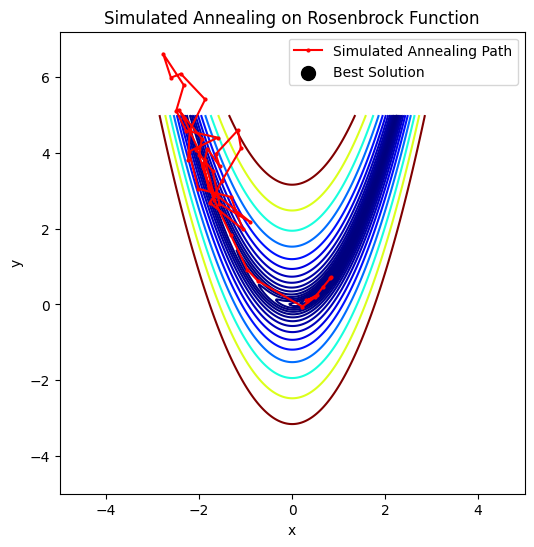

In [33]:
# Рандомизированный метод имитации отжига для двумерного случая
def simulated_annealing_2d(func, bounds, initial_temp, cooling_rate, max_iter):
    current_temp = initial_temp
    current_solution = np.random.uniform(bounds[0], bounds[1], size=2)
    current_value = func(current_solution[0], current_solution[1])
    solutions = [current_solution]
    values = [current_value]
    
    for i in range(max_iter):
        new_solution = current_solution + np.random.uniform(-1, 1, size=2)
        new_value = func(new_solution[0], new_solution[1])
        
        if new_value < current_value or np.exp((current_value - new_value) / current_temp) > np.random.rand():
            current_solution = new_solution
            current_value = new_value
            solutions.append(current_solution)
            values.append(current_value)
        
        current_temp *= cooling_rate
    
    return np.array(solutions), current_solution, current_value, len(values)


solutions, best_solution, best_value, _ = simulated_annealing_2d(rosenbrock, [-5, 5], 1000, 0.95, 1000)

plt.figure(figsize=(6, 6))
plt.contour(X, Y, Z_rosenbrock, levels=np.logspace(-1, 3, 20), cmap='jet')
plt.plot(solutions[:, 0], solutions[:, 1], 'ro-', markersize=2, label='Simulated Annealing Path')
plt.scatter(best_solution[0], best_solution[1], c='black', s=100, label='Best Solution')
plt.title('Simulated Annealing on Rosenbrock Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Compare effectivness

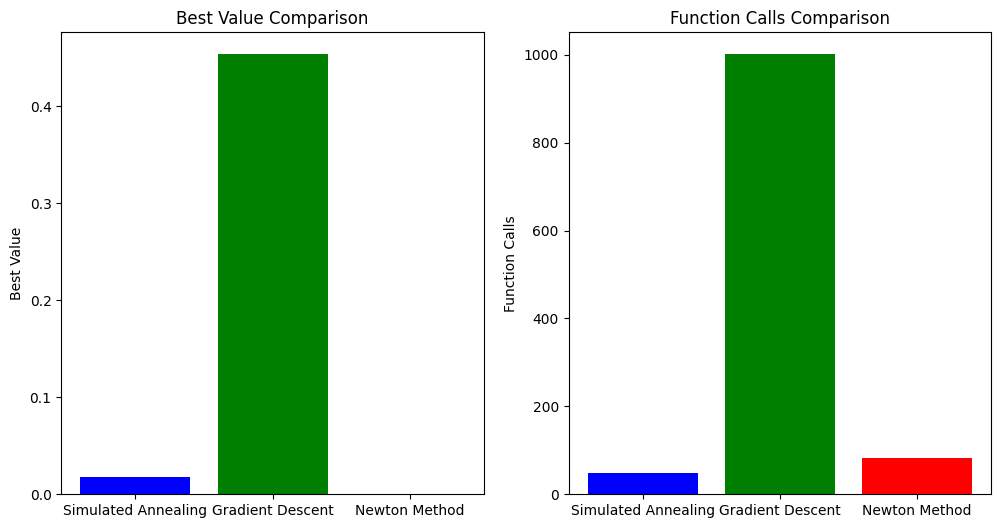

,Method,Best Value,Function Calls
0,Simulated Annealing,1.781138e-02,49
1,Gradient Descent,4.535290e-01,1001
2,Newton Method,3.031438e-10,83


In [34]:
def rosenbrock(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2


def rosenbrock_gradient(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1-xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der


def gradient_descent_path(func, grad_func, initial_point, learning_rate, max_iter):
    path = [initial_point]
    values = [func(initial_point[0], initial_point[1])]
    point = initial_point
    for _ in range(max_iter):
        gradient = grad_func(point)
        point = point - learning_rate * gradient
        path.append(point)
        values.append(func(point[0], point[1]))
    return np.array(path), len(values)


def rosenbrock_hessian(x):
    hess = np.zeros((len(x), len(x)))
    for i in range(len(x)-1):
        hess[i, i] = 1200*x[i]**2 - 400*x[i+1] + 2
        hess[i, i+1] = -400*x[i]
        hess[i+1, i] = hess[i, i+1]
    hess[-1, -1] = 200
    return hess


def newton_method(func, grad_func, hess_func, initial_point, max_iter):
    result = opt.minimize(func, initial_point, method='Newton-CG', jac=grad_func, hess=hess_func, options={'maxiter': max_iter})
    return result.x, result.nit


initial_point = np.array([-1.2, 1.0])
learning_rate = 0.001
max_iter = 1000

solutions_sa, best_solution_sa, best_value_sa, calls_sa = simulated_annealing_2d(rosenbrock, [-5, 5], 1000, 0.95, max_iter)
path_gd, calls_gd = gradient_descent_path(rosenbrock, rosenbrock_gradient, initial_point, learning_rate, max_iter)
best_solution_nm, calls_nm = newton_method(lambda x: rosenbrock(x[0], x[1]), lambda x: rosenbrock_gradient(x), lambda x: rosenbrock_hessian(x), initial_point, max_iter)

results = {
    'Method': ['Simulated Annealing', 'Gradient Descent', 'Newton Method'],
    'Best Value': [best_value_sa, rosenbrock(path_gd[-1][0], path_gd[-1][1]), rosenbrock(best_solution_nm[0], best_solution_nm[1])],
    'Function Calls': [calls_sa, calls_gd, calls_nm]
}

df_results = pd.DataFrame(results)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(df_results['Method'], df_results['Best Value'], color=['blue', 'green', 'red'])
ax[0].set_title('Best Value Comparison')
ax[0].set_ylabel('Best Value')

ax[1].bar(df_results['Method'], df_results['Function Calls'], color=['blue', 'green', 'red'])
ax[1].set_title('Function Calls Comparison')
ax[1].set_ylabel('Function Calls')

plt.show()
df_results

## Optuna

In [20]:
def objective(trial):
    x = trial.suggest_uniform('x', -10, 10)
    return example_function(x)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Лучший результат:", study.best_trial.value)
print("Лучшие параметры:", study.best_trial.params)

[I 2024-05-29 21:54:24,041] A new study created in memory with name: no-name-6cbaeb42-af99-4f25-9abf-bd9e2d7dfa13
/var/folders/bx/7zw8575x0294nd20wrcvh8fc0000gn/T/ipykernel_97313/3584615494.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  x = trial.suggest_uniform('x', -10, 10)
[I 2024-05-29 21:54:24,044] Trial 0 finished with value: 53.41268861673158 and parameters: {'x': -7.091126599574508}. Best is trial 0 with value: 53.41268861673158.
[I 2024-05-29 21:54:24,046] Trial 1 finished with value: -1.571818526998137 and parameters: {'x': -1.5262990457486438}. Best is trial 1 with value: -1.571818526998137.
[I 2024-05-29 21:54:24,047] Trial 2 finished with value: 15.52467037842576 and parameters: {'x': -3.410068415079442}. Best is trial 1 with value: -1.571818526998137.
[I 2024-05-29 21:54:24,048] Trial 3 finished with value: 92.78734090678358 a

Лучший результат: -3.903161772999548
Лучшие параметры: {'x': -0.30676487955268944}


In [21]:
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    max_iter = trial.suggest_int('max_iter', 1000, 10000)
    
    result = gradient_descent(rosenbrock_function, rosenbrock_gradient, initial_point, learning_rate, max_iter)
    return rosenbrock_function(result)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Лучший результат:", study.best_trial.value)
print("Лучшие гиперпараметры:", study.best_trial.params)


[I 2024-05-29 21:54:50,602] A new study created in memory with name: no-name-ccce2b3c-4cb4-4453-95ae-d58307809b38
/var/folders/bx/7zw8575x0294nd20wrcvh8fc0000gn/T/ipykernel_97313/4018548035.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2024-05-29 21:54:50,699] Trial 0 finished with value: 0.0076372157674981156 and parameters: {'learning_rate': 0.0020153348111066273, 'max_iter': 9054}. Best is trial 0 with value: 0.0076372157674981156.
[I 2024-05-29 21:54:50,772] Trial 1 finished with value: 9.223722636319937e-06 and parameters: {'learning_rate': 0.00015788014731148826, 'max_iter': 9315}. Best is trial 1 with value: 9.223722636319937e-06.
[I 2024-05-29 21:54:50,816] Trial 2 finished with value: 7.054912598812796e-06 and parameters: {'learning_rate': 6

Лучший результат: 7.054912598812796e-06
Лучшие гиперпараметры: {'learning_rate': 6.154740502689153e-05, 'max_iter': 5428}
